## Netflix Sentiment Analysis using Twitter Data

### Setup:

In [7]:
# importing libraries
import tweepy
from textblob import TextBlob
from tweepy import OAuthHandler
import pandas as pd
import numpy as np
import re
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
# accessing twitter data 
auth = tweepy.OAuthHandler("CYbS7f11AJPQtFmCXF12WiCcy", "VowKCxGPs1RXXAiYw2kqaFVOI7d4E0yP5YR57MYPGS1p02Lawo")
auth.set_access_token("1606859098771050498-Tds9FDEE6K4pVxFq5LYk8WCS2hDggy", "omRktJWgwjika0WyEBTx8cfFZnhx4SAaQFfzLNrc6AluF")
api = tweepy.API(auth)

In [10]:
# filtering by tweets that contain '@netflix' and are not retweets
search_term = '@netflix -filter:retweets'
tweets = tweepy.Cursor(api.search_tweets, 
                        q=search_term,
                        lang="en").items(1000)


# compiling tweet data into a list
list1 = [[tweet.text, tweet.user.screen_name, tweet.user.location] for tweet in tweets]

In [11]:
# converting the list into a dataframe
df = pd.DataFrame(data=list1, columns = ['tweet', 'user', 'location'])

# converting only the tweets into a list
tweet_list = df.tweet.to_list()

In [12]:
df.head(5)

,tweet,user,location
0,Kudos to @amymurrayxox who starred as Fenrick ...,Deaf,Wales
1,@netflix needs to make an authentic series/fil...,Bethanyannart,
2,@netflix remember when you offered an alternat...,ShriekingNoises,Saint Paul MN
3,Okay I am pissed off! I’m pretty sure that the...,spiritualstiles,24 • she/her • ♈️
4,@quiethandfilms @netflix now I know what to do...,PattankkoYT,#RHCP


Although locational analysis seemed to be possible using tweepy's 'user.location' data, upon using the tool we can see that it results in inaccurate locations. In the dataframe above, '24 • she/her • ♈️' appears as a location for the tweet at index 3, although it is probably a bio for the user rather than their location. Additionally, the next tweet shows a hashtag, which is also not a location. 

In [13]:
# creating a function to clean the tweets
def cleaner(tweet):
    if type(tweet) == np.float64:
        return ""
    r = tweet.lower()
    r = re.sub("'", "", r)
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

# running the tweet list through this function
clean_twts = [cleaner(tweet) for tweet in tweet_list]
clean_twts[:5]


['kudos who starred as fenrick witcher blood origin she worked alon',
 'needs make authentic series film life ed gein',
 'remember when you offered alternative platform where people could actually get non lowest common denomi',
 'okay i am pissed off i m pretty sure that air ambulances did not go rescue people because it was too dange',
 'now i know what do tomorrow']

In [14]:
# using textblob to define the sentiment object 
sentiment_obs = [TextBlob(tweet) for tweet in clean_twts]

# creating a list of sentiment values + tweets
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_obs]

# creating a sentiment dataframe with the polarity value and tweet data
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
sentiment_df


,polarity,tweet
0,0.000000,kudos who starred as fenrick witcher blood ori...
1,0.500000,needs make authentic series film life ed gein
2,-0.150000,remember when you offered alternative platform...
3,0.416667,okay i am pissed off i m pretty sure that air ...
4,0.000000,now i know what do tomorrow
...,...,...
995,0.000000,i must give it look
996,-0.062500,does she have any actual solutions other than ...
997,0.800000,it is also great how people who don t know how...
998,0.500000,they cancel most their shows its shitty


Although sentiment analysis is a valuable tool, the polarity gauged by the textblob sentiment object seems somewhat inaccurate in the context of certain tweets. For example, the tweet at index 998 (end of the dataframe) displays a polarity of 0.5, indicating a positive sentiment. However, the tweet seems to be complaining about the fact that netflix cancels 'most of their shows', using a negative adjective to describe the actions of the platform. Thus, sentiment analysis cannot always be trusted.

In [15]:
# saving polarity column and converting into series
pol = sentiment_df['polarity']
m = pd.Series(pol)

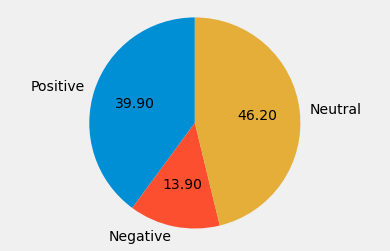

In [16]:
# classifying polarity into categories 'pos' (positive), 'neg' (negative), and 'neu' (neutral)
pos=0
neg=0
neu=0

for items in m:
    if items>0:
        pos=pos+1
    elif items<0:
        neg=neg+1
    else:
        neu=neu+1
        
# creating a pie chart showing the polarity distribution among Netflix related tweets
pieLabels=["Positive","Negative","Neutral"]

populationShare=[pos,neg,neu]

figureObject, axesObject = plt.subplots()

axesObject.pie(populationShare,labels=pieLabels,autopct='%1.2f',startangle=90)

axesObject.axis('equal')

plt.show()

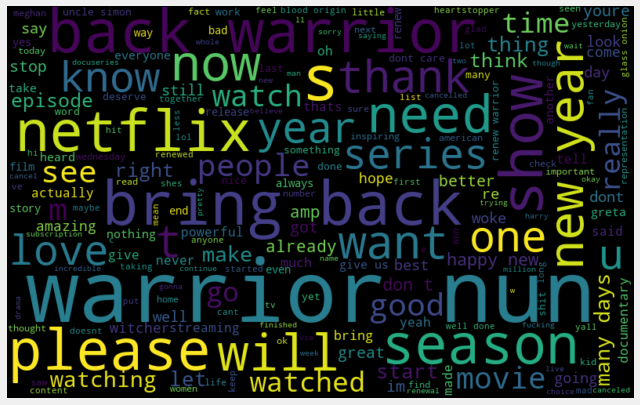

In [17]:
# creating a Wordcloud from the tweets
all_words = ' '.join([text for text in clean_twts])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Examining the wordcloud, we can see that the most frequent/popular words used in tweets containing 'netflix' (apart from 'netflix') are 'warrior', 'nun', 'bring', and 'back'. Warrior Nun is a show that debuted in July 2020, gaining an instant following before being removed from the streaming platform recently in late 2022. Thus, the presence of the words in the title is not surprising, with many fans most likely requesting that Netflix 'please bring back Warrior Nun'.